# Produce Cached `galaxy_ids` for DC2

_Last Updated: Bryce Kalmbach, September 2018_

This is a notebook to produce the cached AGN and SN galaxy_id lists for DC2 Run 2. In this notebook we match the source AGN and SNe galaxies to objects in the galaxy catalogs.

In [2]:
import pandas as pd
from astropy.io import fits
import numpy as np
from desc.sims.GCRCatSimInterface import InstanceCatalogWriter
from lsst.sims.utils import SpecMap
import matplotlib.pyplot as plt
from lsst.utils import getPackageDir
from lsst.sims.photUtils import Sed, BandpassDict, Bandpass
from lsst.sims.catUtils.matchSED import matchBase
import os
%matplotlib inline

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/global/homes/b/brycek/DC2/sims_catalogs/python/lsst/sims/catalogs/db/dbConnection.py:553: UserWarning: Duplicate object type id 4 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/global/homes/b/brycek/DC2/sims_catalogs/python/lsst/sims/catalogs/db/dbConnection.py:553: UserWarning: Duplicate object type id 28 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')


### Create an unsprinkled Instance Catalog 

This is to get the possible AGN and Bulge galaxies to replace with the sprinkler. We use `cosmoDC2_v1.0_image`.

In [ ]:
# First we need to create a catalog without sprinkling
opsimDB = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/minion_1016_desc_dithered_v4.db'
agnDB = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/agn_db_mbh_7.0_m_i_30.0_cosmodc2_180912.db'

t_sky = InstanceCatalogWriter(opsimDB, 'cosmoDC2_v1.0_image_addon_knots', min_mag=30, protoDC2_ra=0,
                              protoDC2_dec=0, sprinkler=False,
                              agn_db_name=agnDB)

In [ ]:
uddf_visit = 197356 # Use a visit we know covers the uDDF field
t_sky.write_catalog(uddf_visit, fov=1.4)

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.19_sim2.8.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sims_catUtils/2.8.0.sims/python/lsst/sims/catUtils/mixins/VariabilityMixin.py:852: RuntimeWarning: divide by zero encountered in true_divide
  dd = _au_to_parsec/parallax


### Load in the galaxy catalogs as dataframes

In [204]:
base_columns = ['prefix', 'uniqueId', 'raPhoSim', 'decPhoSim',
                        'phosimMagNorm', 'sedFilepath', 'redshift',
                        'shear1', 'shear2', 'kappa', 'raOffset', 'decOffset',
                        'spatialmodel']
df_galaxy = pd.read_csv(os.path.join(os.environ['SCRATCH'],
                                     'bulge_gal_cat_197356.txt.gz'),
                                delimiter=' ', header=None,
                                names=base_columns+['majorAxis', 'minorAxis',
                                                    'positionAngle', 'sindex',
                                                    'internalExtinctionModel',
                                                    'internalAv', 'internalRv',
                                                    'galacticExtinctionModel',
                                                    'galacticAv', 'galacticRv'])
df_disk = pd.read_csv(os.path.join(os.environ['SCRATCH'],
                                     'disk_gal_cat_197356.txt.gz'),
                                delimiter=' ', header=None,
                                names=base_columns+['majorAxis', 'minorAxis',
                                                    'positionAngle', 'sindex',
                                                    'internalExtinctionModel',
                                                    'internalAv', 'internalRv',
                                                    'galacticExtinctionModel',
                                                    'galacticAv', 'galacticRv'])
df_agn = pd.read_csv(os.path.join(os.environ['SCRATCH'],
                                     'agn_gal_cat_197356.txt.gz'),
                                 delimiter=' ', header=None,
                                 names=base_columns+['internalExtinctionModel',
                                                     'galacticExtinctionModel',
                                                     'galacticAv', 'galacticRv'])

We calculate the `galaxy_id` for each catalog so that we can join them together and also save it in the cache for the sprinkler.

In [205]:
df_agn['galaxy_id'] = np.right_shift(df_agn['uniqueId'], 10)

In [206]:
df_agn.head()

,prefix,uniqueId,raPhoSim,decPhoSim,phosimMagNorm,sedFilepath,redshift,shear1,shear2,kappa,raOffset,decOffset,spatialmodel,internalExtinctionModel,galacticExtinctionModel,galacticAv,galacticRv,galaxy_id
0,object,9216001276021,53.435559,-26.945783,25.086426,agnSED/agn.spec.gz,0.047209,-0.000021,-0.000006,-0.000045,0,0,point,none,CCM,0.027765,3.1,9000001246
1,object,9216001381493,53.736954,-26.539365,22.238127,agnSED/agn.spec.gz,0.047179,-0.000004,-0.000004,-0.000018,0,0,point,none,CCM,0.035462,3.1,9000001349
2,object,9216001382517,53.765088,-26.474307,21.005609,agnSED/agn.spec.gz,0.047179,-0.000023,-0.000011,-0.000016,0,0,point,none,CCM,0.033978,3.1,9000001350
3,object,9216001385589,53.721399,-26.534063,25.878225,agnSED/agn.spec.gz,0.047179,-0.000004,-0.000002,-0.000025,0,0,point,none,CCM,0.036798,3.1,9000001353
4,object,9216001911925,53.839947,-26.832082,23.400420,agnSED/agn.spec.gz,0.041929,-0.000023,-0.000004,-0.000053,0,0,point,none,CCM,0.035429,3.1,9000001867


In [207]:
df_galaxy['galaxy_id'] = np.right_shift(df_galaxy['uniqueId'], 10)

In [208]:
df_galaxy.head()

,prefix,uniqueId,raPhoSim,decPhoSim,phosimMagNorm,sedFilepath,redshift,shear1,shear2,kappa,...,minorAxis,positionAngle,sindex,internalExtinctionModel,internalAv,internalRv,galacticExtinctionModel,galacticAv,galacticRv,galaxy_id
0,object,9216000199777,53.545161,-27.085175,22.160876,galaxySED/Inst.16E09.0005Z.spec.gz,0.021692,-0.000000e+00,-0.000000,0.000000,...,0.385211,71.035500,4,CCM,-0.000000,1.000000,CCM,0.034481,3.1,9000000195
1,object,9216000809057,53.524564,-26.777660,21.390245,galaxySED/Burst.32E09.02Z.spec.gz,0.047217,6.460591e-07,0.000002,-0.000014,...,1.381355,88.921657,4,CCM,0.028208,0.470165,CCM,0.027570,3.1,9000000790
2,object,9216000943201,53.100701,-26.408293,23.306178,galaxySED/Burst.50E09.02Z.spec.gz,0.047701,1.951021e-05,0.000013,-0.000030,...,0.174265,123.970378,4,CCM,0.023759,0.415067,CCM,0.029433,3.1,9000000921
3,object,9216001003617,53.747821,-26.303476,19.648862,galaxySED/Burst.12E10.0005Z.spec.gz,0.041702,-1.047741e-05,0.000014,-0.000029,...,0.613943,175.763044,4,CCM,0.023664,0.491308,CCM,0.033555,3.1,9000000980
4,object,9216001114209,54.129535,-26.547473,18.680661,galaxySED/Exp.80E09.04Z.spec.gz,0.034863,-1.966811e-05,-0.000008,-0.000043,...,0.598062,88.153042,4,CCM,0.034661,0.500124,CCM,0.037492,3.1,9000001088


In [209]:
df_disk['galaxy_id'] = np.right_shift(df_disk['uniqueId'], 10)

In [210]:
df_disk.head()

,prefix,uniqueId,raPhoSim,decPhoSim,phosimMagNorm,sedFilepath,redshift,shear1,shear2,kappa,...,minorAxis,positionAngle,sindex,internalExtinctionModel,internalAv,internalRv,galacticExtinctionModel,galacticAv,galacticRv,galaxy_id
0,object,9216000184427,53.296930,-27.053911,21.555392,galaxySED/Exp.62E09.002Z.spec.gz,0.022239,-0.0,-0.0,0.0,...,0.456166,16.516023,1,CCM,0.095838,0.435907,CCM,0.029552,3.1,9000000180
1,object,9216000199787,53.545161,-27.085175,27.990970,galaxySED/Exp.50E08.04Z.spec.gz,0.021692,-0.0,-0.0,0.0,...,0.741451,71.035500,1,CCM,0.008377,0.431099,CCM,0.034481,3.1,9000000195
2,object,9216000280683,53.078152,-26.627776,21.921702,galaxySED/Inst.12E09.0005Z.spec.gz,0.022558,-0.0,-0.0,0.0,...,0.494495,92.899542,1,CCM,0.007408,0.335971,CCM,0.030726,3.1,9000000274
3,object,9216000287851,53.521768,-26.715249,20.581922,galaxySED/Exp.62E09.002Z.spec.gz,0.014010,-0.0,-0.0,0.0,...,0.974957,3.872094,1,CCM,0.129536,0.436745,CCM,0.028743,3.1,9000000281
4,object,9216000467051,53.667151,-26.774928,22.032053,galaxySED/Exp.50E09.0005Z.spec.gz,0.015892,-0.0,-0.0,0.0,...,1.108397,154.836313,1,CCM,0.101845,0.433304,CCM,0.035414,3.1,9000000456


### Match the AGN catalog to Twinkles systems

We will go through the AGN catalog and find AGN in the uDDF field that match our properties. We will then save the `galaxy_id` of these AGN and give the corresponding OM10 system a `twinklesId` in the catalog that identifies it with this AGN when the sprinkler runs.

In [7]:
# Load in OM10 lenses we are using in Twinkles

from astropy.io import fits
hdulist = fits.open('../../data/twinkles_lenses_cosmoDC2_v1.0.fits')
twinkles_lenses = hdulist[1].data

In [8]:
# Convert phosimMagNorm to i-band magnitudes for the uDDF AGN
bpDict = BandpassDict.loadTotalBandpassesFromFiles(bandpassNames=['i'])
bp = Bandpass()
imsimBand = bp.imsimBandpass()
agn_fname = str(getPackageDir('sims_sed_library') + '/agnSED/agn.spec.gz')

src_iband = []
src_mag_norm = df_agn['phosimMagNorm'].values
src_z = df_agn['redshift'].values

for src_mag, s_z in zip(src_mag_norm, src_z):
    agn_sed = Sed()
    agn_sed.readSED_flambda(agn_fname)
    agn_sed.redshiftSED(s_z, dimming=True)
    f_norm = agn_sed.calcFluxNorm(src_mag, bp)
    agn_sed.multiplyFluxNorm(f_norm)
    src_iband.append(agn_sed.calcMag(bpDict['i']))

In [9]:
df_agn['i_magnitude'] = src_iband

We want to match the AGN in the uDDF field to lensed systems based upon the redshift and magnitude of the source AGN. In this example we use 0.1 dex in redshift and 0.25 mags in the _i_-band. **(Anytime you use a new catalog this may need to be played with to get the desired number of systems)**

In [10]:
def find_agn_lens_candidates(galz, gal_mag):
        # search the OM10 catalog for all sources +- 0.1 dex in redshift                                                                                               
        # and within .25 mags of the AGN source                                                                                                                     
    w = np.where((np.abs(np.log10(twinkles_lenses['ZSRC']) - np.log10(galz)) <= 0.1) &
                     (np.abs(twinkles_lenses['MAGI_IN'] - gal_mag) <= .25))[0]
    lens_candidates = twinkles_lenses[w]

    return lens_candidates

In [11]:
# Only search within the DDF field
df_agn = df_agn.query('raPhoSim < 53.755 and raPhoSim > 52.495 and decPhoSim < -27.55 and decPhoSim > -28.65')

In [12]:
df_agn = df_agn.reset_index(drop=True)

In [19]:
%%time
density_param = 0.08
good_rows = []
ra_list = []
dec_list = []
gal_ids = []
catalog_row_num = []
catalog_ids = []

for row_idx in range(len(df_agn)):
    
    row = df_agn.iloc[row_idx]
    
    if row_idx % 5000 == 0:
        print(row_idx, len(catalog_ids))

    if row.galaxy_id > 0:
        candidates = find_agn_lens_candidates(row.redshift, row.i_magnitude)
        np.random.seed(np.int(row.galaxy_id) % 4294967296)
        keep_idx = []
        if len(candidates) > 0:
            for candidate_idx, candidate_sys in list(enumerate(candidates['LENSID'])):
                if candidate_sys not in catalog_ids:
                    keep_idx.append(candidate_idx)
            if len(keep_idx) == 0:
                continue
            else:
                candidates = candidates[keep_idx]
        pick_value = np.random.uniform()
        if ((len(candidates) > 0) and (pick_value <= density_param)):
            good_rows.append(row_idx)
            gal_ids.append(row.galaxy_id)
            newlens = np.random.choice(candidates)
            catalog_ids.append(newlens['LENSID'])
            catalog_row_num.append(np.where(twinkles_lenses['LENSID'] == newlens['LENSID'])[0][0])
            ra_list.append(row.raPhoSim)
            dec_list.append(row.decPhoSim)
            #print(len(catalog_ids))

0 0
5000 40
10000 74
15000 129
20000 219
25000 303
30000 357
35000 425
40000 482
45000 555
50000 621
55000 714
60000 789
65000 850
70000 913
75000 985
CPU times: user 20min 9s, sys: 5.22 s, total: 20min 14s
Wall time: 20min 15s


In [20]:
print(len(catalog_ids))

1041


In [21]:
len(good_rows), len(np.unique(good_rows)), len(np.unique(catalog_ids)), len(np.unique(catalog_row_num))

(1041, 1041, 1041, 1041)

In [22]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

Check to see that our cached systems are distributed throughout the uDDF field.

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


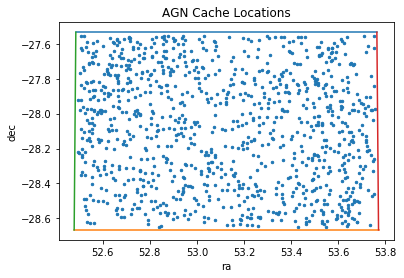

In [23]:
plt.scatter(ra_list, dec_list, s=6)
plt.plot((52.486, 53.764), (-27.533, -27.533))
plt.plot((52.479, 53.771), (-28.667, -28.667))
plt.plot((52.479, 52.486), (-28.667, -27.533))
plt.plot((53.771, 53.764), (-28.667, -27.533))
plt.xlabel(r'ra')
plt.ylabel(r'dec')
plt.title('AGN Cache Locations')
#plt.savefig('agn_cache.png')

In [24]:
catalog_row_sort = np.argsort(catalog_row_num)
catalog_row_num = np.array(catalog_row_num)

In [25]:
# Add in Twinkles ID Number to catalog for matched objects
col_list = []
for col in twinkles_lenses.columns:
        col_list.append(fits.Column(name=col.name, format=col.format, array=twinkles_lenses[col.name][catalog_row_num[catalog_row_sort]]))
col_list.append(fits.Column(name='twinklesId', format='I', array=np.arange(len(good_rows))))

Save this catalog of only the systems we need.

In [27]:
cols = fits.ColDefs(col_list)
tbhdu = fits.BinTableHDU.from_columns(cols)
tbhdu.writeto('../../data/cosmoDC2_v1.0_matched_AGN.fits')

In [28]:
tbhdu.data[:5]

FITS_rec([ (115074, 0, 2,  0.128,  113.5011,  0.2432515,  153.0029 ,  0.07510341,  122.0065 ,  1.06, -0.1656299 ,  0.1122722 ,  23.19,  23.11888,  0.6968272, [ 0.1132, -0.4384,  0.    ,  0.    ], [-0.0756,  0.3502,  0.    ,  0.    ], [-1.0677,  1.8956,  0.    ,  0.    ], [  2.387,   0.   ,   0.   ,   0.   ], [ 0.,  0.,  0.,  0.], [ 0.,  0.,  0.,  0.],  471.641754,   600.109436, -20.6982002,  18.3209515,  0.12800001,  1673.38,  1415.12,  0.,   7101.16,  0.,  0.80348599,  0., 'galaxySED/Burst.12E10.04Z.spec',  17.02627634, 0),
          (431864, 0, 2,  0.2  ,  205.1162,  0.2784123,  -39.1588 ,  0.05159786,   75.38537,  2.16,  0.1176923 , -0.06849588,  24.49,  22.90721,  1.882717 , [ 0.8468, -0.8855,  0.    ,  0.    ], [-0.8346, -0.0972,  0.    ,  0.    ], [ 4.2965, -5.3298,  0.    ,  0.    ], [  0.   ,   8.204,   0.   ,   0.   ], [ 0.,  0.,  0.,  0.], [ 0.,  0.,  0.,  0.],  680.579895,   980.035156, -22.3044796,  17.8517303,  0.2       ,  1709.61,  1451.17,  0.,  17071.5 ,  0.,  1.475094

Save the cached `galaxy_id` info to file

In [29]:
agn_cache = pd.DataFrame(np.array([np.array(gal_ids)[catalog_row_sort], np.arange(len(good_rows))], dtype=np.int).T,
                         columns=['galtileid', 'twinkles_system'])

In [30]:
agn_cache.head()

,galtileid,twinkles_system
0,1028678380,0
1,1113068765,1
2,1228448378,2
3,1303476147,3
4,1048007228,4


In [31]:
agn_cache.tail()

,galtileid,twinkles_system
1036,1079462499,1036
1037,1218556515,1037
1038,1105952313,1038
1039,1319006173,1039
1040,1318934270,1040


In [32]:
#Check that galaxy_ids and twinkles_ids in FITS match up after sort
g_id = np.where(np.array(gal_ids) == agn_cache['galtileid'].values[0])
print(np.array(catalog_ids)[g_id] == tbhdu.data['LENSID'][0])

[ True]


In [33]:
agn_cache.to_csv('cosmoDC2_v1.0_agn_cache.csv', index=False)

### Match to GLSNe catalog

Here we do the same as we did for the AGN and OM10 catalog except with a bulge+disk galaxy catalog and the host galaxy information from the Gravitationally Lensed SNe catalog.

We begin by loading the hdf5 tables for the lensed SNe catalog into dataframes.

In [8]:
sne_systems = pd.read_hdf('/global/cscratch1/sd/brycek/glsne_dc2_v2_with_seds.h5', key='system')
sne_images = pd.read_hdf('/global/cscratch1/sd/brycek/glsne_dc2_v2_with_seds.h5', key='image')

In [213]:
use_gals_df = df_galaxy.query('raPhoSim > 52.495 and raPhoSim < 53.755 and decPhoSim > -28.65 and decPhoSim < -27.55')

In [214]:
len(use_gals_df)

4324372

In [215]:
use_gals_df = use_gals_df.merge(df_disk, on='galaxy_id', suffixes=('_bulge', '_disk'))

Following from Table 3 in Mannucci et al. 2005 (https://www.aanda.org/articles/aa/pdf/2005/15/aa1411.pdf) we are going to use galaxy colors
to scale the sn rate by color as a proxy for galaxy type, but we end up changing it from that a bit to give us good sample sizes of all types in the DDF region.

In [11]:
from lsst.utils import getPackageDir

In [14]:
sims_sed_list = os.listdir(os.path.join(getPackageDir('SIMS_SED_LIBRARY'),
                                        'galaxySED'))

In [18]:
sims_sed_dict = {}
for sed_name in sims_sed_list:
    sed_obj = Sed()
    sed_obj.readSED_flambda(os.path.join(getPackageDir('SIMS_SED_LIBRARY'),
                                         'galaxySED', sed_name))
    sims_sed_dict[os.path.join('galaxySED', sed_name)] = sed_obj

In [27]:
# Filters from http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php
bp_B = Bandpass(wavelen_max = 2700.)
bp_B.setBandpass(wavelen=np.array([360., 380., 400., 420., 460., 480.,
                                   500., 520., 540., 560.]),
                 sb=np.array([0.00, 0.11, 0.92, 0.94, 0.79, 0.58,
                              0.36, 0.15, 0.04, 0.0]))
bp_K = Bandpass(wavelen_max = 2700.)
bp_K.setBandpass(wavelen=np.linspace(1800., 2600., 17),
                 sb=np.array([0.00, 0.10, 0.48, 0.95, 1.00, 0.98,
                              0.96, 0.95, 0.97, 0.96, 0.94, 0.95,
                              0.95, 0.84, 0.46, 0.08, 0.00]))
bp_dict = BandpassDict(bandpassNameList=['B', 'K'], bandpassList=[bp_B, bp_K])

In [217]:
from lsst.sims.photUtils import getImsimFluxNorm
from copy import deepcopy
bk_color = []
i = 0
for sed_name_bulge, redshift, magNorm_bulge, sed_name_disk, magNorm_disk in zip(use_gals_df['sedFilepath_bulge'].values,
                                                                                use_gals_df['redshift_bulge'].values,
                                                                                use_gals_df['phosimMagNorm_bulge'].values,
                                                                                use_gals_df['sedFilepath_disk'].values,
                                                                                use_gals_df['phosimMagNorm_disk'].values):
    if i % 100000 == 0:
        print(i)
    sed_obj_bulge = deepcopy(sims_sed_dict[sed_name_bulge])
    f_norm_b = getImsimFluxNorm(sed_obj_bulge, magNorm_bulge)
    sed_obj_bulge.multiplyFluxNorm(f_norm_b)
    sed_obj_bulge.redshiftSED(redshift)
    
    sed_obj_disk = deepcopy(sims_sed_dict[sed_name_disk])
    f_norm_d = getImsimFluxNorm(sed_obj_disk, magNorm_disk)
    sed_obj_disk.multiplyFluxNorm(f_norm_d)
    sed_obj_disk.redshiftSED(redshift)
    
    sed_obj = Sed()
    sed_obj.setSED(wavelen=sed_obj_bulge.wavelen, flambda=sed_obj_bulge.flambda+sed_obj_disk.flambda)
    
    
    b_val, k_val = bp_dict.magListForSed(sed_obj)
    bk_color.append(b_val - k_val)
    i+=1

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000


In [218]:
bk_color = np.array(bk_color)

In [219]:
# Save so if kernel resets we don't have to do it again.
np.savetxt('bk_color.dat', bk_color)

In [220]:
use_gals_df['bk_color'] = bk_color

In [221]:
use_gals_df = use_gals_df.reset_index(drop=True)

As we did before we match based upon a property in each catalog. Here we use the source redshift of the SNe in the lens catalog and the redshift of the potential host galaxies in the uDDF field. Since we have so many potential host galaxies we tighten up the redshift bounds to 0.01 in dex. We also use the galaxy type from the colors to associate to proper types of host galaxies in the lensed SNe catalog.

In [225]:
def find_sne_lens_candidates(galz, gal_type):#, gal_mag):
    # search the galaxy catalog for all possible host galaxies +- 0.05 dex in redshift

    lens_candidates = sne_systems.query(str('zs < {}'.format(np.power(10, np.log10(galz)+0.01)) + ' and ' +
                                            'zs > {}'.format(np.power(10, np.log10(galz)-0.01))))
        
    if gal_type == 't1':
        lens_candidates = lens_candidates.query('host_type == "kinney-starburst"')
    elif gal_type == 't4':
        lens_candidates = lens_candidates.query('host_type == "kinney-elliptical"')
    else:
        lens_candidates = lens_candidates.query('host_type == "kinney-sc"')

    return lens_candidates

In [320]:
#%%time
density_param = .0003
good_rows_sn = []
gal_ids_sn = []
sys_ids_sn = []
used_systems = []
ra_list_sn = []
dec_list_sn = []
type_sn = []
redshift_sn = []

rd_state = np.random.RandomState(47)

for row_idx in range(len(use_gals_df)):
    
    density_test = rd_state.uniform()
    
    gal_bk = use_gals_df['bk_color'].iloc[row_idx]
    
    if gal_bk < 2.6:
        type_density_param = 1.2*density_param
        gal_type = 't1'
    elif ((2.6 <= gal_bk) and (gal_bk < 3.3)):
        type_density_param = 3.*density_param
        gal_type = 't2'
    elif ((3.3 <= gal_bk) and (gal_bk < 4.1)):
        type_density_param = 2.*density_param
        gal_type = 't3'
    else:
        type_density_param = 3.*density_param
        gal_type = 't4'
    
    if density_test > type_density_param:
        continue
    
    row = use_gals_df.iloc[row_idx]
    
    gal_id = use_gals_df['galaxy_id'].iloc
    if gal_id in df_agn['galaxy_id'].values:
        continue
    
    if len(good_rows_sn) % 50 == 0:
        print(row_idx, len(good_rows_sn))

    if row.galaxy_id > 0:
        #print(gal_type)
        candidates = find_sne_lens_candidates(row.redshift_bulge, gal_type)
        #print(len(candidates))
        np.random.seed(np.int(row.galaxy_id) % 4294967296)
        keep_idx = []
        for candidate_idx in range(len(candidates)):
            if candidates.index[candidate_idx] in used_systems:
                continue
            else:
                keep_idx.append(candidate_idx)
        candidates = candidates.iloc[keep_idx]

        if len(candidates) > 0:
            choice = np.random.choice(np.arange(len(candidates)), p=candidates['weight']/np.sum(candidates['weight']))
            used_systems.append(candidates.index[choice])
            newlens = candidates.iloc[choice]
            #print(len(catalog_ids))
            sys_ids_sn.append(newlens.sysno)
            gal_ids_sn.append(row.galaxy_id)
            ra_list_sn.append(row.raPhoSim_bulge)
            dec_list_sn.append(row.decPhoSim_bulge)
            good_rows_sn.append(row_idx)
            type_sn.append(gal_type)
            redshift_sn.append(row.redshift_bulge)

271 0
81103 50
180222 100
296965 150
405287 200
503453 250
606671 300
710585 350
822453 400
942899 450
1058365 500
1153459 550
1225654 600
1311951 650
1404239 700
1493878 750
1595286 800
1691695 850
1808264 900
1927038 950


In [321]:
len(good_rows_sn), len(ra_list_sn)

(978, 978)

In [322]:
print(len(np.where(np.array(type_sn) == "t1")[0]))
print(len(np.where(np.array(type_sn) == "t2")[0]))
print(len(np.where(np.array(type_sn) == "t3")[0]))
print(len(np.where(np.array(type_sn) == "t4")[0]))

480
143
115
240


Once again check to see that we are spread throught uDDF region.

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


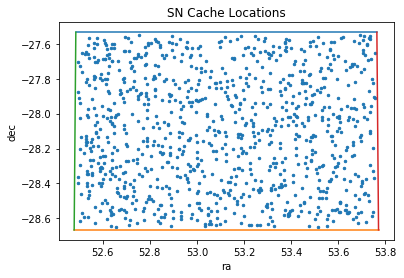

In [323]:
plt.scatter(ra_list_sn, dec_list_sn, s=6)
plt.plot((52.486, 53.764), (-27.533, -27.533))
plt.plot((52.479, 53.771), (-28.667, -28.667))
plt.plot((52.479, 52.486), (-28.667, -27.533))
plt.plot((53.771, 53.764), (-28.667, -27.533))
plt.xlabel('ra')
plt.ylabel('dec')
plt.title('SN Cache Locations')
#plt.savefig('sne_cache.png')

Now we need to join the information in the systems and image dataframes and then save only the ones we are using to file.

In [328]:
keep_systems = sne_systems.iloc[used_systems]

In [329]:
keep_systems['twinkles_sysno'] = np.arange(len(keep_systems)) + 1100

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [330]:
keep_catalog = keep_systems.merge(sne_images, on='sysno')

In [333]:
t_start = keep_catalog['t0'] + keep_catalog['td']

In [334]:
keep_catalog['t_start'] = t_start

In [338]:
keep_catalog.to_csv('cosmoDC2_v1.0_sne_cat.csv', index=False)

Save the cache of `galaxy_ids` and associated `twinklesId` values to file.

In [336]:
sne_cache = pd.DataFrame(np.array([gal_ids_sn, np.arange(len(keep_systems)) + 1100], dtype=np.int).T, columns=['galtileid', 'twinkles_system'])

In [339]:
sne_cache.to_csv('cosmoDC2_v1.0_sne_cache.csv', index=False)

### Check that `galaxy_ids` will not clash when the sprinkler modifies them

We need to make sure that we can adjust the `galaxy_id` values of the sprinkler galaxies so that we can record information in the id values, but we need to make sure the new id values don't clash with `cosmoDC2` id values. We check that below.

In [261]:
import GCRCatalogs
import pandas as pd
from GCR import GCRQuery

In [262]:
catalog = GCRCatalogs.load_catalog('cosmoDC2_v1.0_image')

In [265]:
cosmo_ids = catalog.get_quantities(['galaxy_id'])

In [286]:
smallest_id = np.min(cosmo_ids['galaxy_id'])
largest_id = np.max(cosmo_ids['galaxy_id'])

In [287]:
print(largest_id, smallest_id)

14345538432 1000000000


The highest `galaxy_id` in `cosmoDC2_v1.0_image` is ~1.44e10. Therefore, if we add 1.5e10 to all `galaxy_id` values that are sprinkled then we will be above this. After that we multiply by 10000 to get room to add in the twinkles system numbers in the last 4 digits. If these numbers are less that 2^63 then we will be ok when generating instance catalogs.

In [298]:
offset = np.int(1.5e10)

In [304]:
(2**63) - np.left_shift((largest_id + offset)*10000, 10)

8.9228737233110958e+18

We are under the 2^63 limit. So, we can use this scheme to make sure there are no id clashes and add in the twinkles information as before.